In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')


In [3]:
train.type.unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [4]:
train = train.drop('out_pressure', axis=1)

In [5]:
test = test.drop('out_pressure',axis=1)

In [6]:
train_x_1 = train[(train['type']==0) | (train['type']==4)| (train['type']==5) | (train['type']==6) | (train['type']==7)].values

In [7]:
train_x_2 = train[train['type'] == 1].values

In [8]:
train_x_3 = train[train['type'] == 2].values

In [9]:
train_x_4 = train[train['type'] == 3].values

In [10]:
test_x_1 = test[(test['type']==0) | (test['type']==4)| (test['type']==5) | (test['type']==6) | (test['type']==7)].values

In [11]:
test_x_2 = test[test['type'] == 1].values
test_x_3 = test[test['type'] == 2].values
test_x_4 = test[test['type'] == 3].values

In [12]:
from sklearn.decomposition import PCA

In [13]:
import sys
sys.path.append('C:/Users/User/github/Function/python/')
import eif as iso
import igraph as ig

def branch2num(branch, init_root=0):
    num = [init_root]
    for b in branch:
        if b == 'L':
            num.append(num[-1] * 2 + 1)
        if b == 'R':
            num.append(num[-1] * 2 + 2)
    return num

def gen_graph(branches, g = None, init_root = 0, pre = ''):
    num_branches = [branch2num(i, init_root) for i in branches]
    all_nodes = [j for branch in num_branches for j in branch]
    all_nodes = np.unique(all_nodes)
    all_nodes = all_nodes.tolist()
    if g is None:
        g=ig.Graph()
    for k in all_nodes : g.add_vertex(pre+str(k))
    t=[]
    for j in range(len(branches)):
        branch = branch2num(branches[j], init_root)
        for i in range(len(branch)-1):
            pair = [branch[i],branch[i+1]]
            if pair not in t:
                t.append(pair)
                g.add_edge(pre+str(branch[i]),pre+str(branch[i+1]))
    return g,max(all_nodes)

In [14]:
clf_1 = iso.iForest(train_x_1, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)
clf_2 = iso.iForest(train_x_2, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)
clf_3 = iso.iForest(train_x_3, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)
clf_4 = iso.iForest(train_x_4, sample_size=256, ntrees=500, limit=12, ExtensionLevel=1)

In [15]:
S0 = clf_1.compute_paths(X_in=test_x_1)
S1 = clf_2.compute_paths(X_in=test_x_2)
S2 = clf_3.compute_paths(X_in=test_x_3)
S3 = clf_4.compute_paths(X_in=test_x_4)

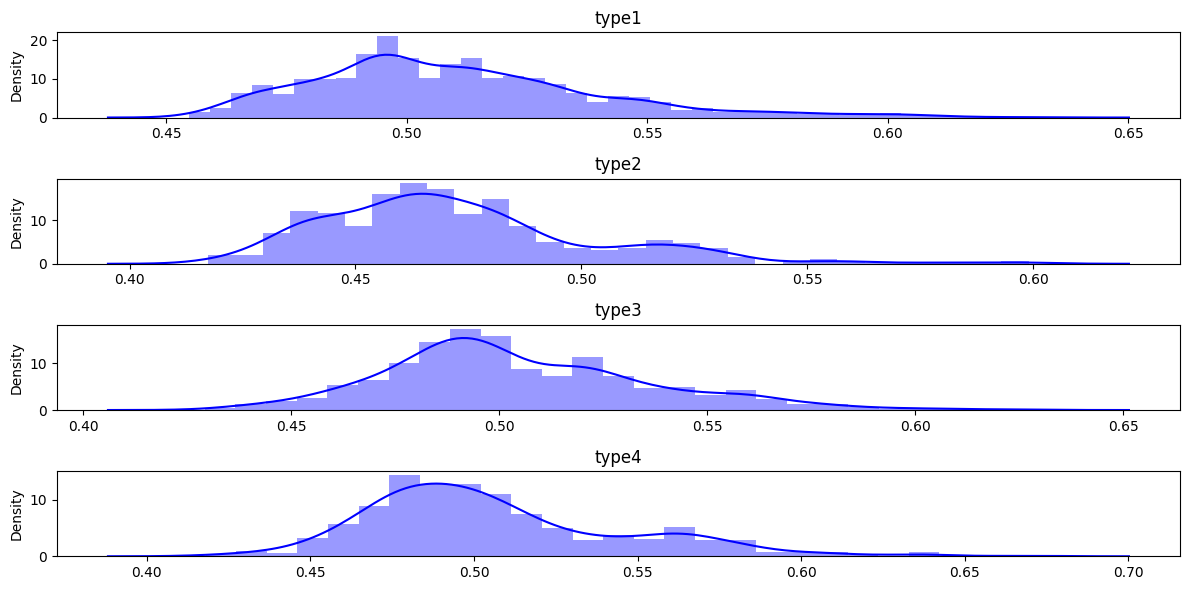

In [18]:
f = plt.figure(figsize=(12,6))

plt.subplot(4,1,1)
sns.distplot(S0, kde=True, color="b")
plt.title('type1')

plt.subplot(4,1,2)
sns.distplot(S1, kde=True, color="b")
plt.title('type2')

plt.subplot(4,1,3)
sns.distplot(S2, kde=True, color="b")
plt.title('type3')

plt.subplot(4,1,4)
sns.distplot(S3, kde=True, color="b")
plt.title('type4')

plt.tight_layout()
plt.show()

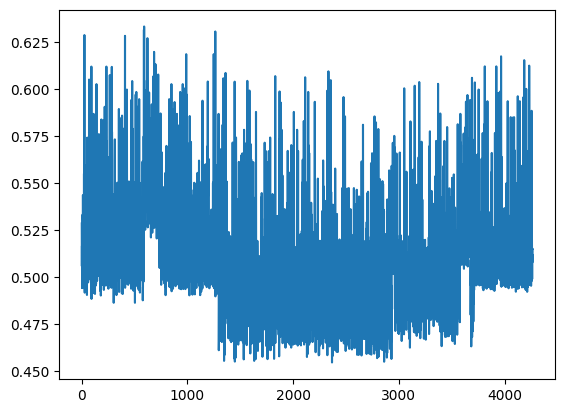

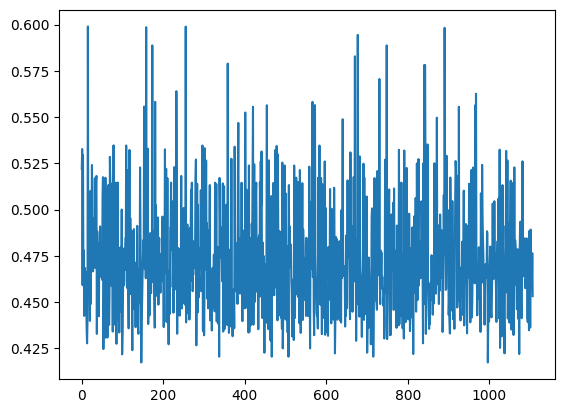

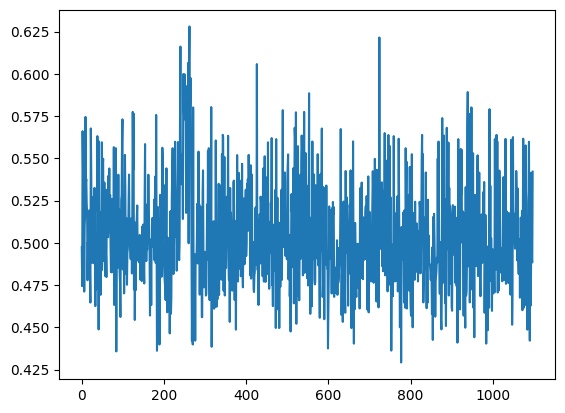

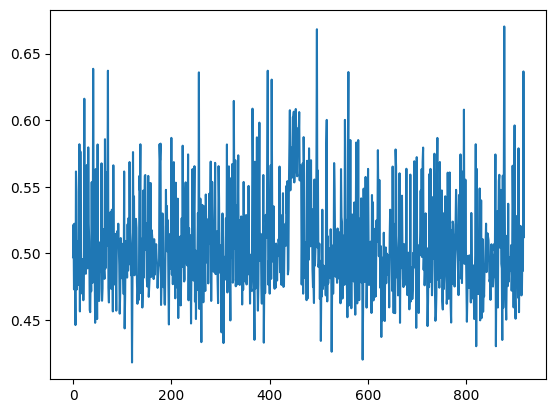

In [19]:
plt.plot(S0)
plt.show()
plt.plot(S1)
plt.show()
plt.plot(S2)
plt.show()
plt.plot(S3)
plt.show()

In [20]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm_1 = GaussianMixture(n_components=4, covariance_type = 'full',n_init=15, random_state=42)
gm_1.fit(train)

GaussianMixture(n_components=4, n_init=15, random_state=42)

In [21]:
print(gm_1.converged_)

True


In [22]:
gm_1.predict(test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
densities = gm_1.score_samples(test)
density_threshold = np.percentile(densities, 4)

In [49]:
density_threshold

-56446.90450995895

Text(0.5, 1.0, 'gmm result')

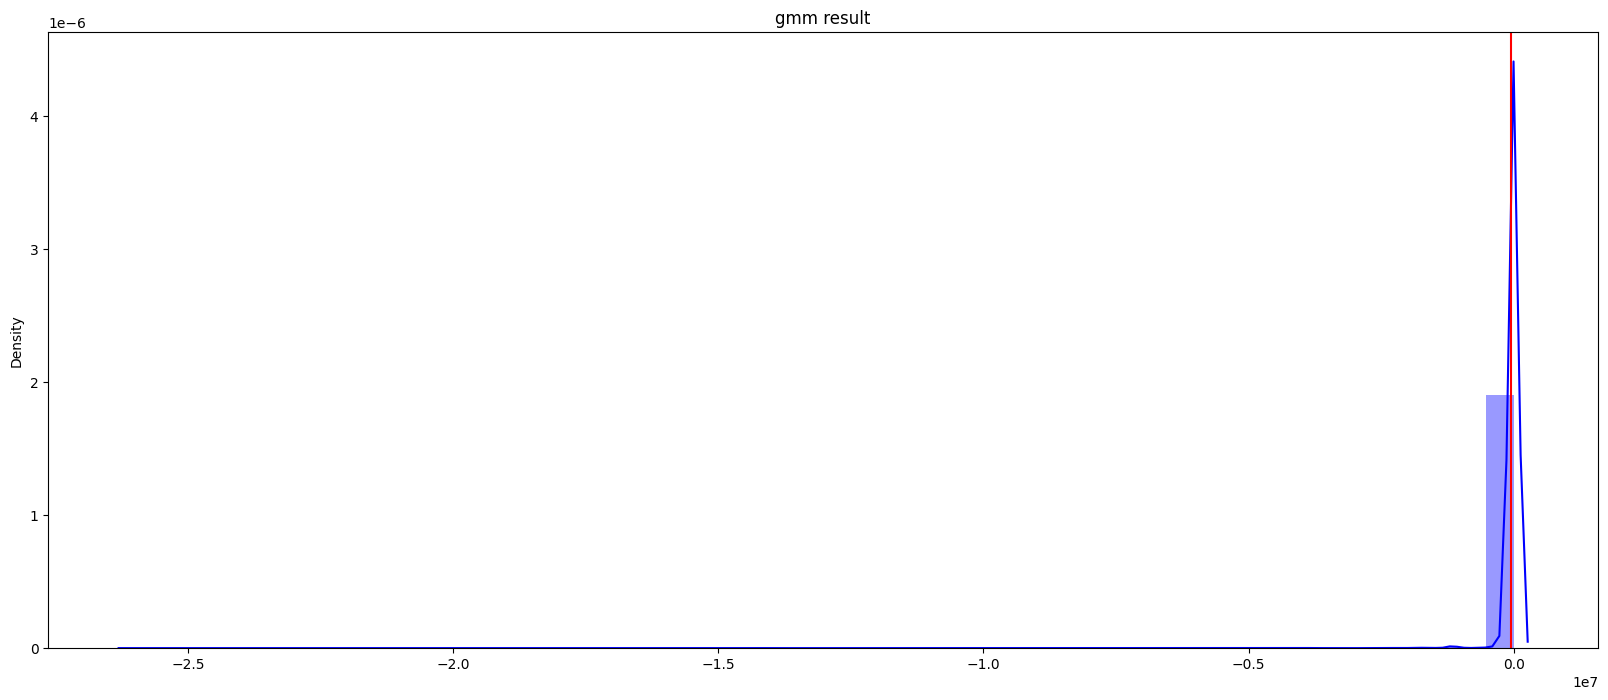

In [50]:
plt.figure(figsize=(20,8))
sns.distplot(densities, kde=True, color="b")
plt.axvline(density_threshold, color = 'red')
plt.title('gmm result')

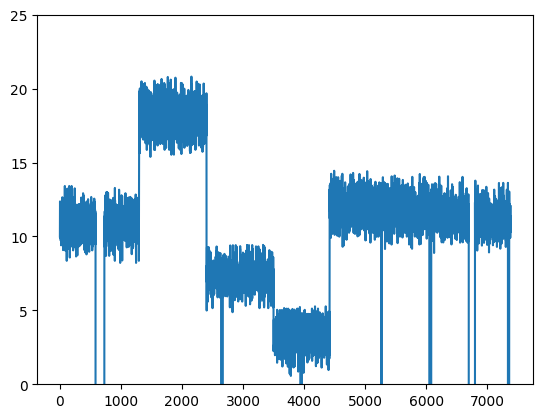

In [51]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')
plt.ylim(0,25)
plt.show()

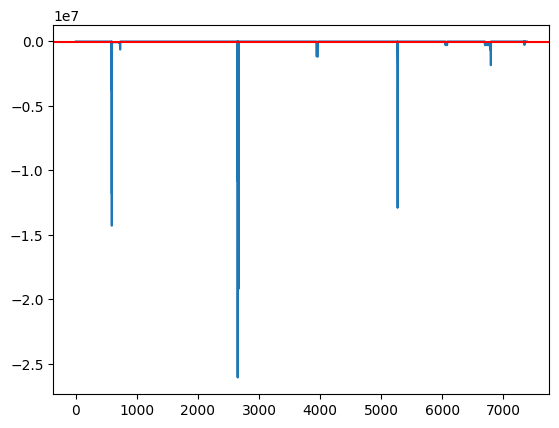

In [52]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')


In [60]:
anomalies = test[densities < density_threshold]

In [63]:
test['label'] = 0

In [77]:
test.loc[anomalies.index.tolist(), 'label'] = 1

test.to_csv('C:/Users/user/Desktop/a.csv', index=False)